In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

# The Actogram

Most of the time, an actigraphy measurement will comprise several days of data with a granularity of 30 seconds to 5 minutes. A standard line plot with all the data on a single trace does not provide a good visualization tool for both understanding small details on the data collected and also analyze patterns between days. The actogram is a plot created in order to provide a better visualization tool. The basic idea is to plot each day on a different line of the same plot or on different plots with the aligned axis. There are basically two kinds of actograms: single plot and double plot.

## Before Starting

Before we start with the Actogram code and examples we will define a few helper functions and load some data to be used.

### Helper functions

We will be using some helper functions already explained in the Loading Data tutorial. 

In [3]:
def actigraphy_load_data(filename):
    f = open(filename, "r")
    count = 0
    while count < 50:
        count += 1

        # Get next line from file
        line = f.readline()
        if '+-------------------------------------------------------+' in line:
            break
    df = pd.read_csv(filename, delimiter = ';', header = count, parse_dates = False)
    df['DATE/TIME'] = pd.to_datetime(df['DATE/TIME'], format = '%d/%m/%Y %H:%M:%S')
    df.set_index( df['DATE/TIME'], inplace = True)
    return df   

def actigraphy_select_period(start_date, end_date):
    index = np.logical_and(df.index >= start_date, df.index < end_date)
    filtered_df = df[index]
    return filtered_df

#### Loading Data

We will start here loading some actigraphy data saved with ActStudio using the helper function defined previously. We will also filter the period to remove the beginning of the data in which the user was not using the ActTrust device.

In [4]:
filename = "Example_Log.txt"
df = actigraphy_load_data(filename)

start_date = pd.Timestamp('2015-12-26 00:00:00')
end_date = df.index[-1]
df = actigraphy_select_period(start_date,end_date)

## Single Plot Actogram

The single plot actogram consists of multiple plots containing each 24 hours of data. It can contain one or more different signals. Most of the time it is used for better visualization of details of the data and, in general, it is used for scoring the actigraphy file into sleep and awake states. Finally, the starting hour of each plot is selected according to the data being analyzed. As an example, if one is visualizing data with sleep happening during the nighttime, a single plot actogram with each plot ranging from 12h to 12h of the following day provides a better view of the sleep pattern.

In [5]:
# We will create a color list to be used sequentially for each signal we add to the plot

color_list = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
    ]

def actigraphy_split_by_day(df, start_hour = 0):
    ldays = []
    ldays_ref = []
    
    #First day is the start of the day of the first Epoch
    sdate = pd.Timestamp(year = df.index[0].year, month = df.index[0].month, day = df.index[0].day)
    if(df.index[0].hour <= start_hour):
        sdate = sdate - pd.Timedelta(hours = start_hour) 
    else:
        sdate = sdate + pd.Timedelta(hours = start_hour)         
    
    while sdate < df.index[-1]:
        day = np.logical_and(df.index >= sdate, df.index < sdate + pd.Timedelta(hours = 24))
        ldays.append(df[day])
        ldays_ref.append(pd.Timestamp(year = sdate.year, month = sdate.month, day = sdate.day))
        sdate += pd.Timedelta(hours = 24)
        
    return ldays, ldays_ref

def actigraphy_single_plot_actogram(df, cols, secondary_y, start_hour):
    ldays = []
    ldays_ref = []
    
    #First day is the start of the day of the first Epoch
    ldays, ldays_ref = actigraphy_split_by_day(df, start_hour)

    specs = [[{"secondary_y": True}]] * len(ldays)
    fig = make_subplots(len(ldays), 1, specs = specs)
    
    for i in range(len(ldays)):
        j = 0
        showlegend = False
        if(i == 0):
            showlegend = True
        for cn in cols: 
            fig.add_trace(go.Scattergl(x=ldays[i].index,
                                          y=ldays[i][cn],
                                          opacity=0.8, 
                                          fillcolor= 'rgb(0,160,255)',line=dict(color=color_list[j%len(color_list)]),
                                          legendgroup=cn,
                                          showlegend=showlegend,
                                          name = cn,
                                         )
                              , i+1, 1,  secondary_y = secondary_y[j])
            j = j+1
        fig.update_xaxes(range=[ldays_ref[i] + pd.Timedelta(hours = 12), ldays_ref[i] + pd.Timedelta(hours = 36)], row=i+1, col=1)
    fig.update_layout(height=len(ldays)*200)
    return fig    

### Example

In the following example, we will plot both the activity (PIM signal) and skin temperature on a single plot actogram.

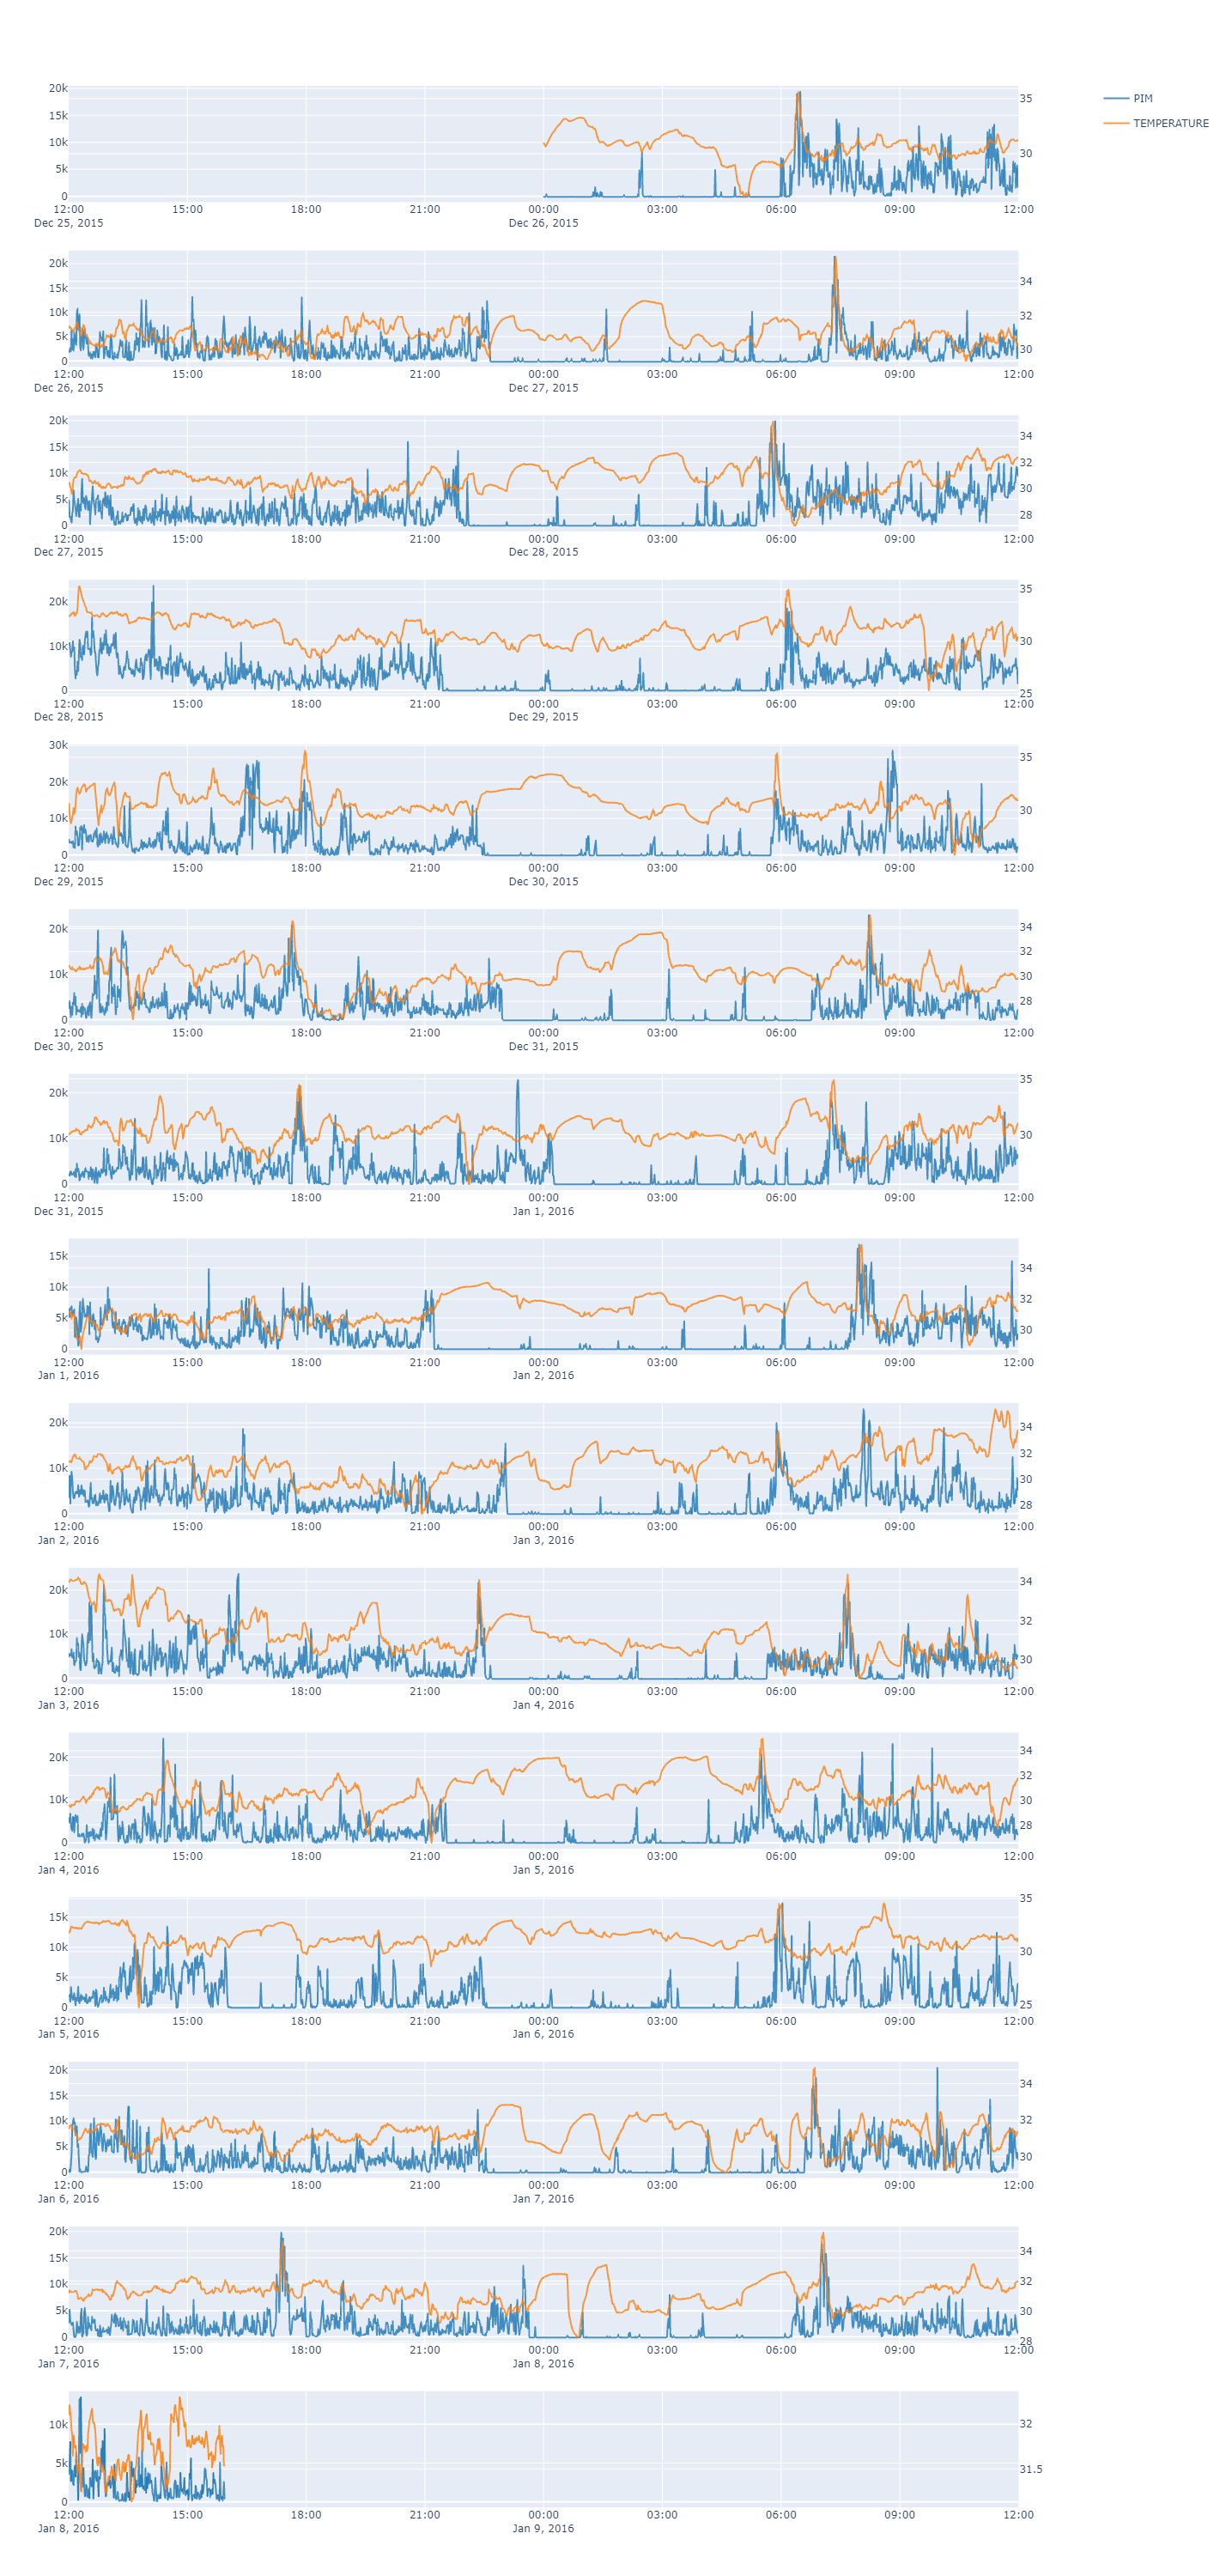

In [6]:
fig = actigraphy_single_plot_actogram(df, ['PIM', 'TEMPERATURE'], [False, True], 12)
fig.show()

## Double Plot Actogram

The double plot actogram consists of a single plot with each line containing 48 hours of data. However, the last 24 hours of a certain line are the same data used on the first 24 hours of the following line. This provides a very good visualization tool for understanding circadian and sleep patterns across the days.

In [8]:
def rescale(x, min_val, max_val):
    resc = (x - min_val)/(max_val - min_val)
    return resc
    

def actigraphy_double_plot_actogram(df, column):
    max_val = max(df[column])*1.1
    min_val = min(df[column])
    if min_val > 0:
        min_val = min_val*0.9
    
    #First day is the start of the day of the first Epoch
    ldays, ldays_ref = actigraphy_split_by_day(df) 
    fig = go.Figure()    
    i = 0
    for i in range(len(ldays)-1):
        d1 = ldays[i]
        d2 = ldays[i+1]
        x1 = d1.index.hour + d1.index.minute/60.0 + d1.index.second/3600.0
        x2 = d2.index.hour + d2.index.minute/60.0 + d2.index.second/3600.0 + 24.0
        x = np.append(x1,x2)
        y = np.append(d1[column],d2[column])
        y = (i+1)-rescale(y, min_val, max_val)
        fig.add_trace(go.Scatter(x=x,y=y,line=dict(color='royalblue')))
        i +=1
    d1 = ldays[-1]
    x = d1.index.hour + d1.index.minute/60.0 + d1.index.second/3600.0
    y = d1[column]
    y = (i+1)-rescale(y, min_val, max_val)
    fig.add_trace(go.Scatter(x=x,y=y,line=dict(color='royalblue')))
    
    
    fig.update_yaxes(range=[len(ldays), 0])    
    fig.update_layout(showlegend=False)
    fig.update_xaxes(tick0=0, dtick=2)
    fig.update_layout(height=len(ldays)*70)

    
    return fig

### Example

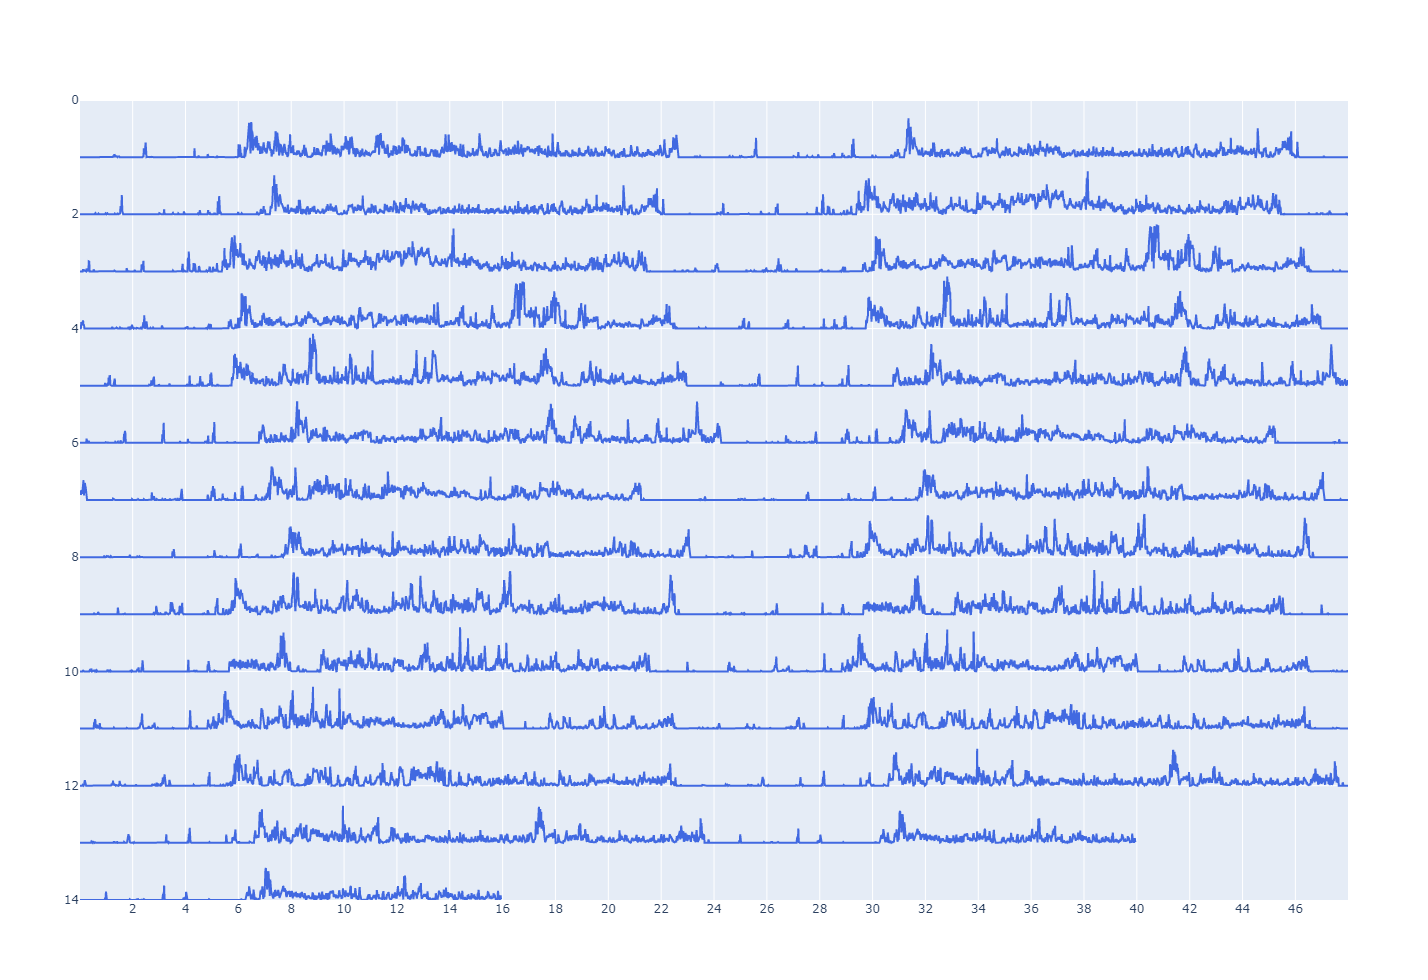

In [9]:
fig = actigraphy_double_plot_actogram(df, 'PIM')
fig.show()